In [4]:
import numpy as np
from itertools import product
import random
from threading import Thread
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class Renderer():
    def __init__(self, chief, content, title=None, dimensions=(800, 800)):
        self.chief = chief
        self.content = content
        self.contents = [content] # para trocar entre janelas
        self.iConteudoAtual = 0 # para marcar qual o atual dentre os varios
        self.title = title
        self.dimensions = dimensions
        self.running = True
        if not self.title:
            self.title = type(chief).__name__   # title é o nome da classe
        
        self.load_sprites()

    def add_content(self,content):
        self.contents.append(content)

    def load_sprites(self):
        self.sprites = dict()
        self.sprites["path"] = '⬛'
        self.sprites["wall"] = '🧱'
        self.sprites["goal"] = '⚽'
        self.sprites["agent"] = '👾' 
        self.sprites["right"] = '➡️'
        self.sprites["up"] = '⬆️'
        self.sprites["left"] = '⬅️' 
        self.sprites["down"] = '⬇️'


    def show(self):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.sprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.sprites.get(obj,'❌'),end='')
            print('')

        


In [6]:
class Agent():
    actions = ['up', 'down', 'left', 'right']
    def __init__(self, x, y, environment, gamma = 0.9, display=True):
        self.environment = environment
        self.x = x
        self.y = y
        self.gamma = gamma
        self.display = display


    def startQ(self, shape):
        """
        livroQ é uma lista de listas de dicionarios,
        ele armazena 
        
        """
        self.book_Q: list[list[dict]] = []
        for i in range(shape[0]):
            self.book_Q.append([])
            for _ in range(shape[1]):
                self.book_Q[i].append(dict())
                for action in self.actions:
                    self.book_Q[i][-1][action] = float("-inf")

    def startV(self, shape):
        """
        livroV é uma lista de listas de dicionarios,
        ele armazena 
        
        """ 
        self.book_V: list[list] = []
        for i in range(shape[0]):
            self.book_V.append([])
            for _ in range(shape[1]):
                
                self.book_V[i].append(float("-inf"))
    
    def startPolicy(self, shape, randomPolicy):
        """
        A policy é uma matriz de caracteres que guarda a action principal
        a ser tomada ate o momento
        
        """
        self.policy: list[list[str]] = []
        for i in range(shape[0]):
            self.policy.append([])
            for j in range(shape[1]):
                if self.environment.symbols[self.environment.original_map[i][j]] == "wall":
                    self.policy[i].append("wall")
                    continue
                if randomPolicy:
                    self.policy[i].append(random.choice(self.actions))
                else:
                    self.policy[i].append(self.actions[0])
        if self.display:
            self.render = Renderer(self, self.policy, "Agente")

    def startReturns(self, shape):
        """
        returns é uma colecao de pares state action guardando um
        dicionario para armazenar o valor maximo de rewards obtidos,
        o numero de vezes que o par state action foi visitado e o ultimo
        episodio em que o par state action foi visitado
        """
        self.returns: list[list[dict]] = []
        for i in range(shape[0]):
            self.returns.append([])
            for j in range(shape[1]):
                self.returns[i].append(dict())
                for action in self.actions:
                    self.returns[i][j][action] = {"value": 0, "count": 0, "lastEpisode": 0}

    def setEnvironment(self, environment):
        self.environment = environment
    
    def setPos(self, position):
        self.x = position[1]
        self.y = position[0]

    def move(self, action):
        return self.environment.move(self, action)
    
    def get_action(self):
        return self.policy[self.y][self.x]


In [31]:
class LearningStrategy():
    def train(self, episodes):
        pass

    def setup(self, environment, agent):
        self.environment = environment
        self.agent = agent

    def evaluate(self):
        pass

class MonteCarlo(LearningStrategy):
    def __init__(self) -> None:
        pass

    
    def train(self, episodes, randomPolicy = True, exploration_chance = 0):
        # Initialize
        shape = self.environment.get_size()
        self.agent.startPolicy(shape, randomPolicy)
        self.agent.startReturns(shape)
        self.agent.startQ(shape)

        for ep in range(episodes):
            if ep % (episodes//10) == 0:
                print(f"{ep=}")
            # escolhe posicao aleatoria valida para o agente
            while True:
                state = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[state[0]][state[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            # escolhe uma action diferente da dita pela politica atual
            for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                action = random.choice(self.agent.actions)
                if action != self.agent.policy[state[0]][state[1]]:
                    # se a action nao te leva para uma parede
                    if self.environment.util(state, action): 
                        break
            else:
                action = self.agent.policy[state[0]][state[1]]
            self.episode(state, action, max_steps= shape[1]*shape[0], exploration_chance = exploration_chance)
            g = 0
            for t in range(len(self.agent.recalls)-1, -1, -1): 
                memory = self.agent.recalls[t]  # memory = (state, action, reforco)
                g = self.agent.gamma*g + memory[2]
                # verifica se o par state action ja foi inserido em returns
                if self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] != ep:
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] = ep
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"] += g
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"] += 1
                    media = self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"]/self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"]
                    self.agent.book_Q[memory[0][0]][memory[0][1]][memory[1]] = media
                    self.agent.policy[memory[0][0]][memory[0][1]] = max(self.agent.actions, key = lambda action: self.agent.book_Q[memory[0][0]][memory[0][1]][action])    # recebe a action que maximiza o valor de Q

    def episode(self, state, action, max_steps, exploration_chance=0):
        step_count = 0
        self.agent.recalls = []
        self.environment.setAgentPos(state[0], state[1])

        while (not self.environment.in_terminal_state()) and (step_count < max_steps):  # enquanto nao estiver em um state terminal
            step_count +=1  # incrementa o numero de passos
            lastPos = (self.agent.y, self.agent.x)
            reward = self.environment.move(self.agent,action) # realiza a action e recebe a recompensa
            self.agent.recalls.append((lastPos, action, reward)) # guarda o passo
            if random.random() < exploration_chance:
                for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                    action = random.choice(self.agent.actions)
                    # se a action nao te leva para uma parede
                    if self.environment.util(state, action): break
            else:
                action = self.agent.get_action() # escolhe uma action de acordo com a politica
    def evaluate(self):
        shape = self.environment.get_size()
        
        self.agent.startReturns(shape)
        self.agent.startV(shape)
        ep = 0
        for i in range(shape[0]):
            for j in range(shape[1]):
                state = (i,j)
                action = self.agent.policy[state[0]][state[1]]
                if(action == 'wall'):
                    continue
                self.episode(state, action, max_steps= shape[1]*shape[0], exploration_chance=0)
                g = 0
                for t in range(len(self.agent.recalls)-1, -1, -1): 
                    memory = self.agent.recalls[t]  # memory = (state, action, reforco)
                    g = self.agent.gamma*g + memory[2]
                    # verifica se o par state action ja foi inserido em returns
                    if self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] != ep:
                        self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] = ep
                        self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"] += g
                        self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"] += 1
                        media = self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"]/self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"]
                        self.agent.book_V[memory[0][0]][memory[0][1]] = media
                ep+=1


class SARSA(LearningStrategy):
    ...

class LinearFunctionApproximation(LearningStrategy):
    ...

class QLearning(LearningStrategy):
    ...

In [24]:
class Environment:
    default_symbols = {"agent": '@', "wall": '#', "path": '.', "goal":'$'}
    def __init__(self, path, display=True) -> None:
        self.display = display
        self.original_map = self.load_map(path)
        self.map = self.copy_map(self.original_map)
        self.wait_time = 0

        if self.display:
            self.render = Renderer(self, self.map, "Ambiente")
            print(self.render)

    def copy_map(self, map):
        map_copy = []
        for row in map:
            map_copy.append([])
            for cell in row:
                map_copy[-1].append(cell)
        return map_copy

    def getAgent(self) -> Agent:
        return self.agent

    def in_terminal_state(self):
        return self.original_map[self.agent.y][self.agent.x] == self.default_symbols["goal"]


    def load_map(self, path):
        """
        Dado o caminho path, le um file txt e retorna uma matriz
        O txt consiste de uma row contendo o numero n (número de
        rows do grid) e m (número de caracteres diferentes no grid),
        seguido de m rows explicando o que sao os caracteres no 
        file e por fim n rows contendo o grid que sao caracteres
        """

        grid = []
        self.symbols = dict()
        self.rewards = {"agent": 0, "wall": 0, "path": 0, "goal":0}
        with open(path, 'r') as file:
            m, n = map(int, file.readline().split())
            for _ in range(m):
                row = file.readline().split()
                self.symbols[row[0]] = row[1]
                self.rewards[row[1]] = int(row[2])
            for i in range(n):
                row = file.readline()
                grid.append([])
                for j in range(len(row)):
                    char = row[j]
                    if char == '\n':
                        continue
                    if self.symbols[char] == 'agent':
                        self.agent = Agent(x=j, y=i, environment=self, display=self.display)
                        char = self.default_symbols["path"]
                    grid[-1].append(self.default_symbols[self.symbols[char]])
        return grid
    
    def move(self, agent, action):
        """
        Dada uma action, move o agente no map
        a action pode ser "up", "down", "left" ou "right"
        """
        time.sleep(self.wait_time)
        
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        final_pos = (agent.y+direction[action][0], agent.x+direction[action][1])
        if self.map[final_pos[0]][final_pos[1]] != self.default_symbols["wall"]:
            # seta a posicao atual como caminho
            self.map[agent.y][agent.x] = self.original_map[agent.y][agent.x]
            
            # seta a posicao final como o agente
            self.map[final_pos[0]][final_pos[1]] = self.default_symbols["agent"]
            
            # atualiza a posicao do agente
            agent.setPos(final_pos)
        # retorna o reforco da posicao final 
        return self.rewards[self.symbols[self.original_map[agent.y][agent.x]]]

    def util(self, pos, action):
        """
        Dada uma posicao e uma action, retorna o que tem na posicao destino
        """
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        final_pos = (pos[0]+direction[action][0], pos[1]+direction[action][1])
        return self.symbols[self.map[final_pos[0]][final_pos[1]]] != "wall"

    def get_size(self):
        return len(self.map), len(self.map[0])
    
    def setAgentPos(self, i, j):
        self.map[self.agent.y][self.agent.x] = self.original_map[self.agent.y][self.agent.x]
        self.agent.setPos((i, j))
        self.map[i][j] = self.default_symbols["agent"]

In [32]:
learning_strategy = MonteCarlo()
environment = Environment('./salas/sala5.txt', True)
agent = environment.getAgent()
learning_strategy.setup(environment, agent)

learning_strategy.train(100000, exploration_chance=0.3)
print("Done")

ep=0
ep=10000
ep=20000
ep=30000
ep=40000
ep=50000
ep=60000
ep=70000
ep=80000
ep=90000
Done


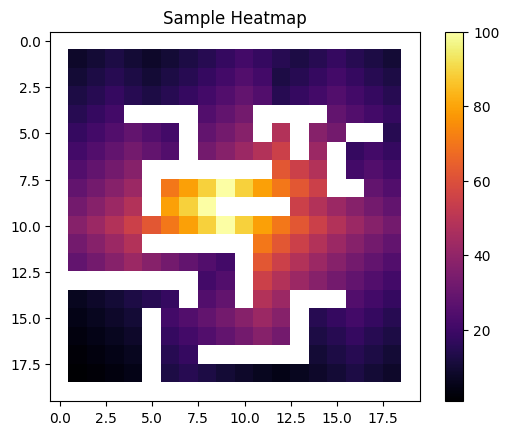

In [34]:
learning_strategy.evaluate()
#learning_strategy.environment.render.show()
#learning_strategy.agent.render.show()
def create_heatmap(data, cmap='viridis', title='Heatmap'):
    """
    Create a heatmap from a list of lists of floats.

    Parameters:
    - data: List of lists of floats representing the heatmap data.
    - cmap: Colormap for the heatmap (default is 'viridis').
    - title: Title for the heatmap (default is 'Heatmap').
    """
    data = np.array(data, dtype=float)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the heatmap using imshow
    im = ax.imshow(data, cmap=cmap)

    # Add a colorbar to the right of the heatmap
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set the title
    ax.set_title(title)

    # Show the plot
    plt.show()

# Example usage:

create_heatmap(learning_strategy.agent.book_V, cmap='inferno', title='Sample Heatmap')

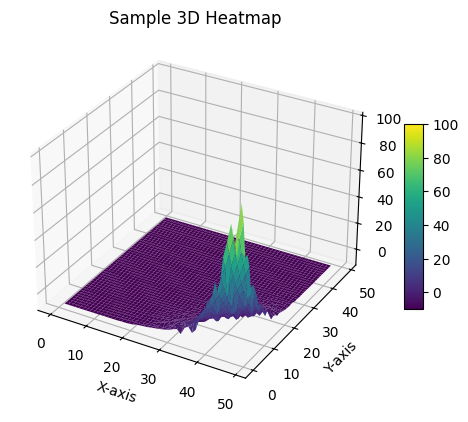

In [121]:

from mpl_toolkits.mplot3d import Axes3D

def create_3d_heatmap(data, cmap='viridis', title='3D Heatmap'):
    """
    Create a 3D grid-like heatmap from a list of lists of floats.

    Parameters:
    - data: List of lists of floats representing the heatmap data.
    - cmap: Colormap for the heatmap (default is 'viridis').
    - title: Title for the 3D heatmap (default is '3D Heatmap').
    """
    data = np.array(data, dtype=float)
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    X, Y = np.meshgrid(x, y)

    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D heatmap using plot_surface
    surface = ax.plot_surface(X, Y, data, cmap=cmap)

    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Set the title
    ax.set_title(title)

    # Add a color bar to the plot
    fig.colorbar(surface, shrink=0.5, aspect=10)

    # Show the plot
    plt.show()

create_3d_heatmap(learning_strategy.agent.book_V, cmap='viridis', title='Sample 3D Heatmap')